[Jump_to lesson 8 video](https://course19.fast.ai/videos/?lesson=8&t=1850)

# Matrix multiplication from foundations

The *foundations* we'll assume throughout this course are:

- Python
- Python modules (non-DL)
- pytorch indexable tensor, and tensor creation (including RNGs - random number generators)
- fastai.datasets

## Import & Unit Test in Jupyter Notebook

In [1]:
# % means magical command in IPython
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [3]:
test_eq(MYNAME,'Gary')
test_eq(TEST,'test')

In [4]:
# To run tests in console:
# ! python run_notebook.py 01_matmul.ipynb

## Get data

In [5]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

In [6]:
import os
import torchvision.datasets as datasets
root = '../data'
if not os.path.exists(root):
    os.mkdir(root)
    
# if not exist, download mnist dataset
train_set = datasets.MNIST(root=root, train=True, download=True)
test_set = datasets.MNIST(root=root, train=False, download=True)

In [7]:
x_train, x_valid = train_set.train_data.split([50000, 10000])
y_train, y_valid = train_set.train_labels.split([50000, 10000])

/opt/anaconda3/envs/snowflakes/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/anaconda3/envs/snowflakes/lib/python3.8/site-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [8]:
x_train = x_train.view(50000, -1)
x_valid = x_valid.view(10000, -1)

In [9]:
print(x_train.shape, type(x_train))
print(x_valid.shape)
print(y_train.shape, type(y_train))
print(y_valid.shape)

torch.Size([50000, 784]) <class 'torch.Tensor'>
torch.Size([10000, 784])
torch.Size([50000]) <class 'torch.Tensor'>
torch.Size([10000])


In [10]:
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [11]:
n,c = x_train.shape
assert n==y_train.shape[0]==50000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [12]:
mpl.rcParams['image.cmap'] = 'gray'

In [13]:
img = x_train[0]

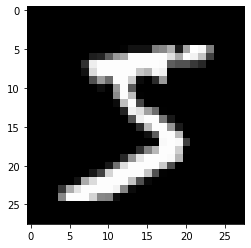

In [14]:
plt.imshow(img.view((28,28)));

## Initialize Model

In [15]:
weights = torch.randn(784,10)

In [16]:
bias = torch.zeros(10)

## Matrix Multiplication

### 1. The Brute Force Way

In [17]:
def matmul(a,b):
    a_row, a_col = a.shape 
    b_row, b_col = b.shape
    assert a_col == b_row
    # initialize output c
    c = torch.zeros(a_row, b_col)
    # c[i][j] = a[i][k_1] * b[k_1][j] + a[i][k_2] * b[k_2][j] + .... a[i][k_a_col] * b[k_b_row][j]
    for i in range(a_row):
        for j in range(b_col):
            for k in range(a_col):
                # [i,j] is the same as [i][j] in numpy indexing style
                c[i,j] += a[i,k] * b[k,j]
    return c

In [47]:
m1 = x_valid[:5].float()
m2 = weights.float()

In [48]:
%time t1=matmul(m1, m2)

CPU times: user 787 µs, sys: 1.02 ms, total: 1.8 ms
Wall time: 931 µs


In [49]:
t1.shape

torch.Size([5, 10])

### 2. Optimize via Elementwise Ops

- When we say Python is slow, we don't just mean twice as slow, we mean ~1000 times too slow. The way we make things faster is starting from the innermost loop and try to remove Python. Here we can leverage PyTorch's elementwise ops which is a lot faster.

- Here, instead of multiplying and adding via loop, we do an element-wise multiplication for each of the row/column vector and then sum the resulting vector.


In [50]:
def matmul(a,b):
    a_row, a_col = a.shape 
    b_row, b_col = b.shape
    assert a_col == b_row
    # initialize output c
    c = torch.zeros(a_row, b_col)
    for i in range(a_row):
        for j in range(b_col):
            # Must use [i, :] numpy-style slicing for torch tensors slicing to work
            c[i,j] = (a[i,:] * b[:,j]).sum()
            
    return c

In [51]:
%timeit -n 10 _=matmul(m1, m2)

The slowest run took 5.26 times longer than the fastest. This could mean that an intermediate result is being cached.
2.53 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Unit Test

- You can see this new matmul is already 500+ times faster than the brute force
- We use torch.allclose to test because floating points can be practically the same but still off in the computer's eyes. As you can see, get_percentage_equal would say they're only 6% similar even though test_near passes

In [52]:
t2 = matmul(m1, m2)

In [53]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [54]:
test_near(t1,t2)

In [55]:
# this is what you shouldn't use to compare tensor with floats
def get_percentage_equal(x1, x2):
    nonequal_elements = int((x1 != x2).sum())
    equal_elements = int((x1 == x2).sum())
    equal_percentage = equal_elements / (nonequal_elements + equal_elements)
    return equal_percentage

get_percentage_equal(t1, t2)

0.18

### 3. Optimize via Broadcast

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    The term broadcasting describes how numpy treats arrays with 
    different shapes during arithmetic operations. Subject to certain 
    constraints, the smaller array is “broadcast” across the larger 
    array so that they have compatible shapes. Broadcasting provides a 
    means of vectorizing array operations so that looping occurs in C
    instead of Python. It does this without making needless copies of 
    data and usually leads to efficient algorithm implementations.
    
In addition to the efficiency of broadcasting, it allows developers to write less code, which typically leads to fewer errors.

#### Useful Broadcast Functions

In [56]:
m = torch.randn(3, 3)
c = tensor([10.,20,30])
print(c)
print(m)
# expand_as show what c broadcasted against m would look like
t = c.expand_as(m)

tensor([10., 20., 30.])
tensor([[-0.2377,  0.4730, -0.3850],
        [-1.9068,  0.9716, -1.3973],
        [ 1.7361, -0.3436, -0.9131]])


In [57]:
# storage shows what is actually being stored in memory 
# (the same row is NOT actually copied but instead reused)
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [58]:
# stide here tells you when going from row to row, you move 0 down, but 
# when going from col to col, you move 1 down. 
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [59]:
# broadcast against row
c.unsqueeze(0)

tensor([[10., 20., 30.]])

In [60]:
# broadcast against column
c.unsqueeze(1)

tensor([[10.],
        [20.],
        [30.]])

#### These two below are exactly equivalent but the latter has better syntax

In [61]:
c.shape, c.unsqueeze(0).shape,c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [62]:
c.shape, c[None].shape,c[:,None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means '*all preceding dimensions*'

#### Matmul with broadcasting

In [63]:
def matmul(a,b):
    a_row, a_col = a.shape 
    b_row, b_col = b.shape
    assert a_col == b_row
    # initialize output c
    c = torch.zeros(a_row, b_col)
    for i in range(a_row):
        # unsqueeze (a_c,) into (a_c, 1), then we broadcast it against b, which has (a_c, b)
        broadcast_res = (a[i][:,None] * b)
        c[i] = broadcast_res.sum(dim=0)
    return c

In [64]:
%timeit -n 10 _=matmul(m1, m2)

346 µs ± 112 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
t3 = matmul(m1, m2)

#### Unit Test

In [66]:
test_near(t1, t3)
test_near(t2, t3)

### 4. Optimize with Einstein summation

Einstein summation (`einsum`) is a compact representation for combining products and sums in a general way. From the numpy docs:

"The subscripts string is a comma-separated list of subscript labels, where each label refers to a dimension of the corresponding operand. Whenever a label is repeated it is summed, so `np.einsum('i,i', a, b)` is equivalent to `np.inner(a,b)`. If a label appears only once, it is not summed, so `np.einsum('i', a)` produces a view of a with no changes."

#### Pros of Einsum:

- more concise and efficient code more quickly with less errors.

- "domain-specific languages like einsum can sometimes be compiled to high-performing code, and an einsum-like domain-specific language is in fact the basis for the recently introduced Tensor Comprehensions in PyTorch which automatically generate GPU code and auto-tune that code for specific input sizes."


**Bottom line: Einstein used this notation to avoid/omit summation signs. Different rules get out of hand quickly and will need to revisit this notatin down the line if it keeps recurring. Just remember that repeated indices are what were summed over under Sigma (https://mathworld.wolfram.com/EinsteinSummation.html)**

In [67]:
# c[i,j] += a[i,k] * b[k,j]
# c[i,j] = (a[i,:] * b[:,j]).sum()
def matmul(a,b): return torch.einsum('ik,kj->ij', a, b)

In [68]:
%timeit -n 10 _=matmul(m1, m2)

The slowest run took 8.91 times longer than the fastest. This could mean that an intermediate result is being cached.
227 µs ± 171 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [69]:
885000/55

16090.90909090909

In [70]:
test_near(t1, matmul(m1, m2))

### 5. PyTorch Ops Optimization

- We can use pytorch's function or operator directly for matrix multiplication. 
- PyTorch's matmul is even faster than everything above because it does everything above with added memory optimizations. For example, when you're doing multiplying big matrices like we are here, cache can't hold that much data, so when you're doing the row by column multiplication (let's say row1 * col1), by the time it gets to the end of the column1 and need to do (row2 * col1), the cache no longer has the beginning of col1 and has to start over.
- Optimization would be to break matrix down into smaller matrices so we can utilize more the cache. Pytorch doesn't even write this optimization itself, it just pushes it off to companies like Nvidia who does this for them because to do this, you need to write assembly code.
- This is why upcoming languages like Swift is important because it allows us to directly write optimizations that traditionally were only written by these companies and very limited


In [71]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 6.93 times longer than the fastest. This could mean that an intermediate result is being cached.
15.3 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [72]:
# time comparison vs pure python:
885000/18

49166.666666666664

In [73]:
# @ is like matmul but even more general
t2 = m1@m2

In [74]:
test_near(t1, t2)

In [75]:
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

## Export

In [76]:
!python notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to exp/nb_01.py
